In [58]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from mtcnn import mtcnn
import cv2

In [17]:
model_file = 'model/facenet_keras.h5'
FRmodel = tf.keras.models.load_model(model_file)
# summarize input and output shape
print(FRmodel.inputs)
print(FRmodel.outputs)

[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(?, 128) dtype=float32>]


In [18]:
# Should be 22808144
print("Total Params:", FRmodel.count_params())

Total Params: 22808144


In [42]:
FRmodel.load_weights("model/facenet_keras_weights.h5")

In [47]:
# Imports for face processing
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray

In [107]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
#     image = Image.open(filename)
    image = cv2.imread(filename)
    #print("file downloaded... \r")
    # convert to RGB, if needed
#     image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    
        #-----------------------
    # Skip this because hopefully it's already done ( by lfw )!
#     detector = mtcnn.MTCNN()
#     # detect faces in the image
#     results = detector.detect_faces(pixels)
#     # extract the bounding box from the first face
#     x1, y1, width, height = results[0]['box']
#     # bug fix
#     x1, y1 = abs(x1), abs(y1)
#     x2, y2 = x1 + width, y1 + height
#     # extract the face
#     face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    #-----------------------
    face = pixels
#     image = Image.fromarray(face)
#     image = image.resize(required_size)
    image = image[...,::-1]
    image = cv2.resize(image, required_size)

    face_array = asarray(image)
    #print("file downloaded... processed")
    return face_array

In [50]:
# load images and extract faces for all images in a directory
def load_faces_from_folder(directory):
    faces = list()
    for filename in listdir(directory):
        #print("loading file ", filename)
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
    return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces_from_folder(path)
        labels = [subdir for _ in range(len(faces))]
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [110]:
# get the face embedding for one face
def img_to_embedding(face_pixels, FRmodel):
    # print('start')
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    # print('starting prediction')
    yhat = FRmodel.predict(samples)
    # print('done with prediction')
    return yhat[0]

def face_list_to_embedding_list(face_pixels_list, model):
    return [img_to_embedding(face, model) for face in face_pixels_list]

# load a dataset that contains one subdir for each class that in turn contains images
def create_embeddings_from_dataset(directory, model):
    pictures = list()
    embeddings = list()
    names = list()
    # enumerate folders, on per class
    totalDownloaded = 0
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces_from_folder(path)
        emb_list = face_list_to_embedding_list(faces, model)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        pictures.extend(faces)
        embeddings.extend(emb_list)
        names.extend(labels)
        
        totalDownloaded = totalDownloaded + 1
        if (totalDownloaded > 1000):
            break
        
    return asarray(pictures), asarray(embeddings), asarray(names)

# Shows a picture of a face from the pixel values
def show_face_from_pixels(face_pixels):
    pyplot.imshow(face_pixels)

In [111]:
dataset = 'lfw-deepfunneled/'
pictures, embeddings, names = create_embeddings_from_dataset(dataset, FRmodel)

>loaded 1 examples for class: Dominic_Monaghan
>loaded 1 examples for class: Stan_Kasten
>loaded 1 examples for class: Lisa_Stone
>loaded 1 examples for class: Francisco_Urenda
>loaded 2 examples for class: Mike_Brey
>loaded 1 examples for class: Gregor_Gysi
>loaded 1 examples for class: Neil_Goldman
>loaded 1 examples for class: Rachel_Roy
>loaded 2 examples for class: Carolina_Moraes
>loaded 1 examples for class: Ian_Knop
>loaded 1 examples for class: Dean_Jacek
>loaded 1 examples for class: Lucio_Angulo
>loaded 6 examples for class: Charlton_Heston
>loaded 1 examples for class: Ivan_Lee
>loaded 1 examples for class: Hilmi_Akin_Zorlu
>loaded 2 examples for class: Ellen_Engleman
>loaded 1 examples for class: Mike_Duke
>loaded 1 examples for class: Richard_Chamberlain
>loaded 1 examples for class: Kaye_Young
>loaded 1 examples for class: John_Lawrence
>loaded 1 examples for class: Mark_Everson
>loaded 1 examples for class: Ron_Zook
>loaded 1 examples for class: Alisha_Richman
>loaded 4

>loaded 2 examples for class: Mario_Kreutzberger
>loaded 2 examples for class: Zafarullah_Khan_Jamali
>loaded 2 examples for class: Lee_Jun
>loaded 1 examples for class: Brandon_Jones
>loaded 2 examples for class: Gordon_Campbell
>loaded 1 examples for class: Tom_Foy
>loaded 2 examples for class: Hal_Sutton
>loaded 2 examples for class: Peter_Bacanovic
>loaded 1 examples for class: Sylvia_Plachy
>loaded 1 examples for class: Reinhard_Buetikofer
>loaded 1 examples for class: Roger_Lyons
>loaded 2 examples for class: Olivia_Newton-John
>loaded 1 examples for class: Peter_Hartz
>loaded 3 examples for class: Milo_Maestrecampo
>loaded 1 examples for class: Michael_Guiler
>loaded 1 examples for class: Harald_Ringstorff
>loaded 2 examples for class: Elizabeth_Taylor
>loaded 1 examples for class: Laurel_Clark
>loaded 1 examples for class: James_McPherson
>loaded 1 examples for class: Alejandro_Fernandez
>loaded 1 examples for class: Hashan_Tillakaratne
>loaded 2 examples for class: OJ_Simpson


>loaded 3 examples for class: Martina_Hingis
>loaded 1 examples for class: Bruce_Arena
>loaded 1 examples for class: John_Herrington
>loaded 1 examples for class: William_Hurt
>loaded 1 examples for class: Ilie_Nastase
>loaded 1 examples for class: Ken_Loach
>loaded 1 examples for class: Avril_Lavigne
>loaded 2 examples for class: Alan_Mulally
>loaded 1 examples for class: Suh_Chung-won
>loaded 5 examples for class: Robert_Kocharian
>loaded 1 examples for class: James_Meredeth
>loaded 2 examples for class: Chang_Dae-whan
>loaded 1 examples for class: Danis_Tanovic
>loaded 1 examples for class: Francisco_Garcia
>loaded 1 examples for class: Huan_Chung_Yi
>loaded 1 examples for class: Goran_Zivkovic
>loaded 1 examples for class: Lloyd_Mudiwa
>loaded 1 examples for class: Dustan_Mohr
>loaded 1 examples for class: Robbie_Coltrane
>loaded 3 examples for class: Lynn_Redgrave
>loaded 2 examples for class: Mark_Dacey
>loaded 1 examples for class: Eva_Mendes
>loaded 1 examples for class: Martin

>loaded 1 examples for class: Mike_OConnell
>loaded 3 examples for class: James_Caan
>loaded 1 examples for class: Mario_Austin
>loaded 1 examples for class: Troy_Garity
>loaded 4 examples for class: Ethan_Hawke
>loaded 4 examples for class: Bernard_Landry
>loaded 1 examples for class: Raul_Castaneda
>loaded 1 examples for class: Michael_Diekmann
>loaded 5 examples for class: Antonio_Banderas
>loaded 1 examples for class: Pat_Wharton
>loaded 1 examples for class: Don_Flanagan
>loaded 5 examples for class: Christine_Baumgartner
>loaded 1 examples for class: Thomas_Daily
>loaded 1 examples for class: Alberto_Sordi
>loaded 1 examples for class: John_Leguizamo
>loaded 1 examples for class: William_Cocksedge
>loaded 3 examples for class: Noah_Wyle
>loaded 1 examples for class: Ray_Liotta
>loaded 1 examples for class: Rodney_Rempt
>loaded 1 examples for class: Fatmir_Limaj
>loaded 1 examples for class: Ashley_Judd
>loaded 1 examples for class: Mireille_Jospin-Dandieu
>loaded 1 examples for c

>loaded 3 examples for class: Stockard_Channing
>loaded 1 examples for class: Hugh_Jessiman
>loaded 1 examples for class: Nancy_Greenlaw
>loaded 1 examples for class: Gaston_Gaudio
>loaded 1 examples for class: Zach_Pillar
>loaded 1 examples for class: Paula_Abdul
>loaded 1 examples for class: Walter_Woods
>loaded 1 examples for class: Javier_Saviola
>loaded 1 examples for class: Kate_Richardson
>loaded 1 examples for class: Lee_Ann_Terlaji
>loaded 2 examples for class: Gregory_Hines
>loaded 1 examples for class: Otto_Schily
>loaded 1 examples for class: Will_Self
>loaded 1 examples for class: John_Duprey
>loaded 1 examples for class: Jim_Parque
>loaded 1 examples for class: Duncan_Fletcher
>loaded 3 examples for class: Emmanuelle_Beart
>loaded 1 examples for class: Teri_Garr
>loaded 4 examples for class: Roberto_Carlos
>loaded 10 examples for class: Tom_Cruise
>loaded 1 examples for class: James_Dingemans
>loaded 1 examples for class: Mohammaed_Ahmad_Al_Jarallah
>loaded 1 examples for

>loaded 1 examples for class: David_Hanson
>loaded 1 examples for class: Hugh_Carey
>loaded 2 examples for class: Mesut_Yilmaz
>loaded 1 examples for class: Osama_Al_Baz
>loaded 1 examples for class: Dalia_Rabin-Pelosoff
>loaded 1 examples for class: Stephen_Thompson
>loaded 2 examples for class: John_Rowland
>loaded 1 examples for class: Festus_Mogae
>loaded 1 examples for class: Darvis_Patton
>loaded 3 examples for class: Carlos_Manuel_Pruneda
>loaded 28 examples for class: Jack_Straw
>loaded 1 examples for class: Scott_Dalton
>loaded 2 examples for class: Rod_Blagojevich
>loaded 1 examples for class: Allan_Wagner
>loaded 1 examples for class: Rachel_Corrie
>loaded 1 examples for class: Mary_Blige
>loaded 1 examples for class: Mitch_Kupchak
>loaded 1 examples for class: Joaquim_Rodriguez
>loaded 3 examples for class: Robbie_Williams
>loaded 1 examples for class: Gene_Autry
>loaded 1 examples for class: Isabela_Moraes
>loaded 1 examples for class: Paul_Schrader
>loaded 1 examples for 

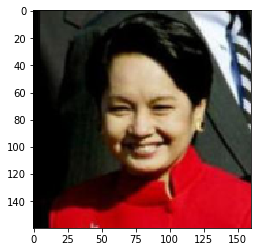

In [115]:
# img1 = cv2.imread('lfw-deepfunneled/Doug_Moe/Doug_Moe_0001.jpg')
# img = img1[...,::-1]
# img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
# img.shape
# pyplot.imshow(pictures[200])

In [117]:
randomize = np.arange(len(pictures))
np.random.shuffle(randomize)
pictures2 = pictures[randomize]
embeddings2 = embeddings[randomize]
names2 = names[randomize]

In [123]:
train_size = 1800
train_pics = pictures2[:train_size]
train_embs = embeddings2[:train_size]
train_name = names2[:train_size]

test_size = int((int(len(pictures2))-train_size)/2)
test_pics = pictures2[train_size:train_size+test_size]
test_embs = embeddings2[train_size:train_size+test_size]
test_name = names2[train_size:train_size+test_size]

dev_pics = pictures2[train_size+test_size:]
dev_embs = embeddings2[train_size+test_size:]
dev_name = names2[train_size+test_size:]

# sanity check
print('train set size: ', len(train_pics))
print('test set size: ', len(test_pics))
print('test set size: ', len(dev_pics))

train set size:  1800
test set size:  241
test set size:  241


In [124]:
savez_compressed('train-data2.npz', train_pics, train_embs, train_name)
savez_compressed('dev-data2.npz', test_pics, test_embs, test_name)
savez_compressed('test-data2.npz', dev_pics, dev_embs, dev_name)